In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import shap

In [49]:
# Load the .csv
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [50]:
# Remove missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Convert the final column to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Label encoding for categorical variables
le = LabelEncoder()
for column in ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
               'PaperlessBilling', 'PaymentMethod']:
    df[column] = le.fit_transform(df[column])

# Separate the independent variables (X) and the dependent variable (y)
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn']

In [61]:
# Split the dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
# Initialize the RandomForest model
rf_model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=500,
                       random_state=42)

In [69]:
# Predictions on the test data
y_pred = rf_model.predict(X_test)

# Probability predictions (test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Probability predictions (train)
y_train_pred_prob = rf_model.predict_proba(X_train)[:, 1]

# ROC curve (test)
fpr, tpr, tresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC curve (train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrixo:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7985781990521327
Confusion matrixo:
 [[1401  148]
 [ 277  284]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.87      1549
           1       0.66      0.51      0.57       561

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110



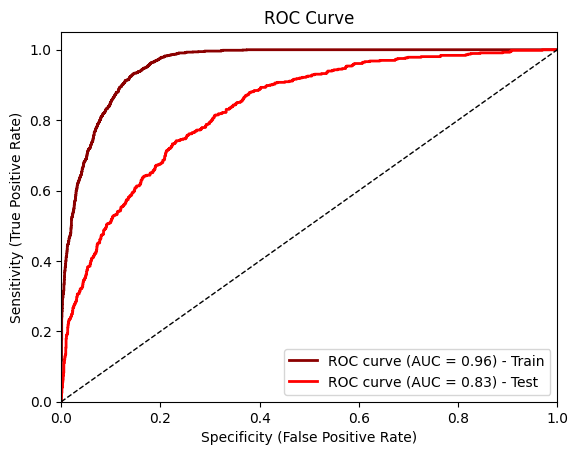

In [70]:
# Plot a graph with the ROC curve
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkred', lw=2, label=f'ROC curve (AUC = {roc_auc_train:.2f}) - Train')
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}) - Test')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [65]:
# Fit the scaler on the training data and transform both the training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(rf_model.predict, shap.kmeans(X_train_scaled, 10))

In [66]:
# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test)

100%|██████████████████████████████████████████████████████████████████████████████| 2110/2110 [11:51<00:00,  2.96it/s]


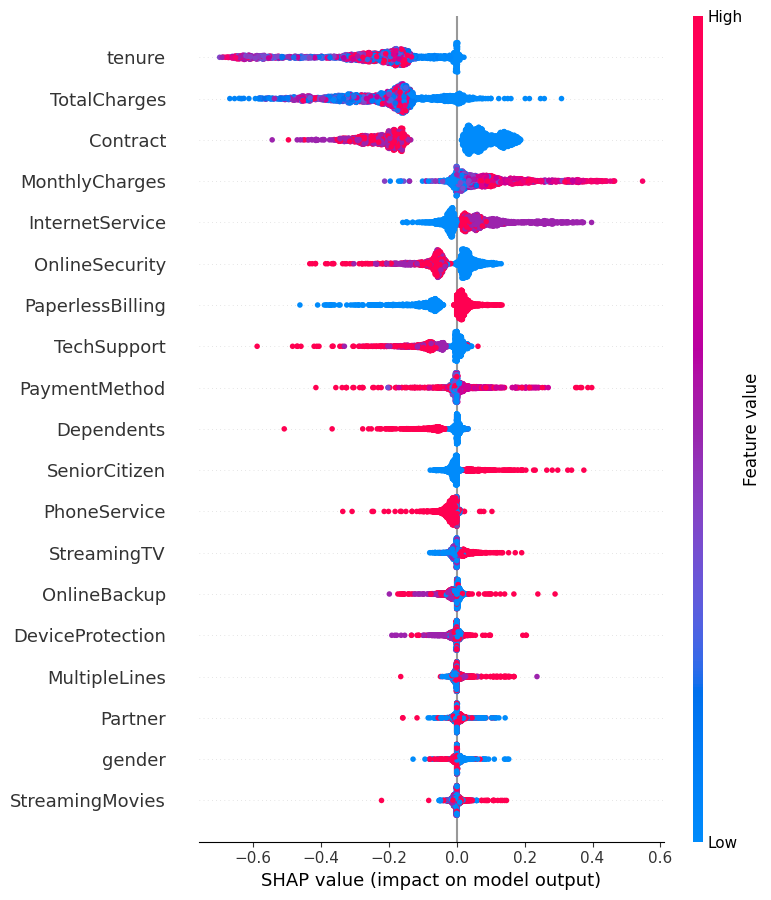

In [68]:
# Plot the graph
shap.summary_plot(shap_values, X_test, feature_names=X.columns)